# What is GAN (Generative Adversarial Network)?


* GAN is basically a way of training a generative model using a supervised learning problem.
* There are 2 basic requirements namely, Generator : Model used to generate plausible or fake samples from already available samples and discriminator : Model used to classify the given samples as real or fake.
* The two models are trained together in a zero-sum game until the discriminator is fooled about half the time.
* A single training cycle involves first selecting a batch of real images from the problem domain. A batch of latent points is generated and fed to the generator model to synthesize a batch of images. The discriminator is then updated using the batch of real and generated images, minimizing binary cross-entropy loss used in any binary classification problem.The generator is then updated via the discriminator model. This means that generated images are presented to the discriminator as though they are real (not generated) and the error is propagated back through the generator model. This has the effect of updating the generator model toward generating images that are more likely to fool the discriminator.
	
![](https://miro.medium.com/max/1800/1*TKr1dtcNgJCA8uYY1OhmSg.png)

This is a basic implementation of Generative Adversarial Network to generate fake images of cats. I am a complete beginner in GANs so feel free to correct/suggest topics.


Code referred from [this post](https://towardsdatascience.com/getting-started-with-gans-using-pytorch-78e7c22a14a5)

# GANs for Cats

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dir = './input/cats'
print(os.listdir(dir))

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg', '10007.jpg', '10008.jpg', '10009.jpg', '1001.jpg', '10010.jpg', '10011.jpg', '10012.jpg', '10013.jpg', '10014.jpg', '10015.jpg', '10016.jpg', '10017.jpg', '10018.jpg', '10019.jpg', '1002.jpg', '10020.jpg', '10021.jpg', '10022.jpg', '10023.jpg', '10024.jpg', '10025.jpg', '10026.jpg', '10027.jpg', '10028.jpg', '10029.jpg', '1003.jpg', '10030.jpg', '10031.jpg', '10032.jpg', '10033.jpg', '10034.jpg', '10035.jpg', '10036.jpg', '10037.jpg', '10038.jpg', '10039.jpg', '1004.jpg', '10040.jpg', '10041.jpg', '10042.jpg', '10043.jpg', '10044.jpg', '10045.jpg', '10046.jpg', '10047.jpg', '10048.jpg', '10049.jpg', '1005.jpg', '10050.jpg', '10051.jpg', '10052.jpg', '10053.jpg', '10054.jpg', '10055.jpg', '10056.jpg', '10057.jpg', '10058.jpg', '10059.jpg', '1006.jpg', '10060.jpg', '10061.jpg', '10062.jpg', '10063.jpg', '10064.jpg', '10065.jpg', '10066.jpg', '10067.jpg', '

In [3]:
##printing first 20 image names
print(os.listdir(dir+'/cats')[:20])

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg', '10007.jpg', '10008.jpg', '10009.jpg', '1001.jpg', '10010.jpg', '10011.jpg', '10012.jpg', '10013.jpg', '10014.jpg']


In [4]:
image_size = 64
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [7]:
#show_batch(train_dl)

In [8]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')


In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
is_cuda_available()

CUDA available. Training on GPU!


device(type='cuda')

In [11]:
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


In [12]:
#basic cnn with convolutional layers and leaky relu as activation fn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
#show_images(fake_images)

torch.Size([256, 3, 64, 64])


In [16]:
generator = to_device(generator, device)

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [18]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [19]:

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [22]:
save_samples(0, fixed_latent, show=False)

print()

Saving generated-images-0000.png



In [23]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [24]:
lr = 0.0003
epochs = 30

In [25]:
losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr)

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 4.9866, loss_d: 0.2019, real_score: 0.8707, fake_score: 0.0425
Saving generated-images-0001.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 3.5002, loss_d: 0.3610, real_score: 0.8655, fake_score: 0.1799
Saving generated-images-0002.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 3.6381, loss_d: 0.7969, real_score: 0.7827, fake_score: 0.4024
Saving generated-images-0003.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 2.8958, loss_d: 0.6834, real_score: 0.6800, fake_score: 0.2085
Saving generated-images-0004.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 2.3990, loss_d: 0.6578, real_score: 0.7857, fake_score: 0.2871
Saving generated-images-0005.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 3.9584, loss_d: 0.7907, real_score: 0.7078, fake_score: 0.2994
Saving generated-images-0006.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 2.8510, loss_d: 0.7293, real_score: 0.6444, fake_score: 0.1308
Saving generated-images-0007.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 4.1252, loss_d: 0.8909, real_score: 0.7434, fake_score: 0.3982
Saving generated-images-0008.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 2.7084, loss_d: 0.7484, real_score: 0.5745, fake_score: 0.0753
Saving generated-images-0009.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 5.9473, loss_d: 0.9266, real_score: 0.9260, fake_score: 0.5364
Saving generated-images-0010.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 7.3895, loss_d: 0.6759, real_score: 0.9576, fake_score: 0.4218
Saving generated-images-0011.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 2.8238, loss_d: 0.6905, real_score: 0.7121, fake_score: 0.2226
Saving generated-images-0012.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 3.6696, loss_d: 0.5211, real_score: 0.6982, fake_score: 0.0900
Saving generated-images-0013.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 4.1282, loss_d: 0.5773, real_score: 0.8043, fake_score: 0.2728
Saving generated-images-0014.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 3.7196, loss_d: 0.6269, real_score: 0.6183, fake_score: 0.0297
Saving generated-images-0015.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 4.5523, loss_d: 0.7250, real_score: 0.9379, fake_score: 0.4422
Saving generated-images-0016.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 6.7675, loss_d: 1.0851, real_score: 0.9624, fake_score: 0.6064
Saving generated-images-0017.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 7.6729, loss_d: 0.9380, real_score: 0.9566, fake_score: 0.5618
Saving generated-images-0018.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 4.4830, loss_d: 0.9032, real_score: 0.8651, fake_score: 0.4794
Saving generated-images-0019.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 5.3218, loss_d: 0.7873, real_score: 0.8705, fake_score: 0.4417
Saving generated-images-0020.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 5.3393, loss_d: 0.6957, real_score: 0.8832, fake_score: 0.4015
Saving generated-images-0021.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 6.6760, loss_d: 0.7805, real_score: 0.9453, fake_score: 0.4535
Saving generated-images-0022.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 6.8001, loss_d: 5.0508, real_score: 0.0188, fake_score: 0.0001
Saving generated-images-0023.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 3.4845, loss_d: 0.5110, real_score: 0.6774, fake_score: 0.0659
Saving generated-images-0024.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 3.8688, loss_d: 0.4139, real_score: 0.8866, fake_score: 0.2359
Saving generated-images-0025.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 3.8657, loss_d: 0.8252, real_score: 0.9655, fake_score: 0.4870
Saving generated-images-0026.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 5.6061, loss_d: 0.9289, real_score: 0.9115, fake_score: 0.5148
Saving generated-images-0027.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 3.8490, loss_d: 0.2563, real_score: 0.8960, fake_score: 0.1265
Saving generated-images-0028.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 3.7126, loss_d: 0.1715, real_score: 0.9172, fake_score: 0.0751
Saving generated-images-0029.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 3.3512, loss_d: 0.5122, real_score: 0.8276, fake_score: 0.2456
Saving generated-images-0030.png


In [ ]:
from IPython.display import Image

One Fake generated image:

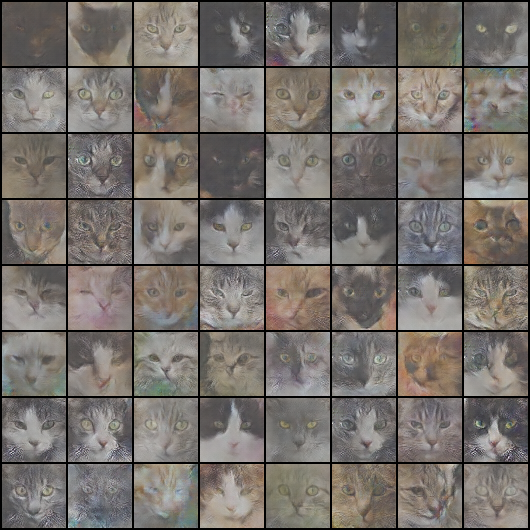

In [ ]:
Image('./generated/generated-images-0033.png')

In [ ]:

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

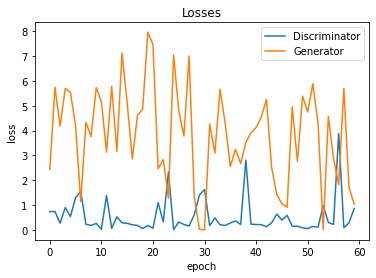

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

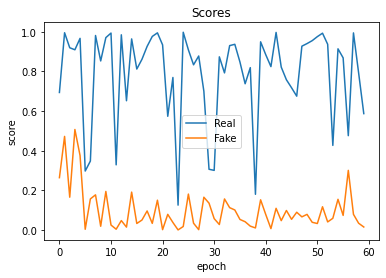

In [ ]:

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

Saving generated-images-0000.png


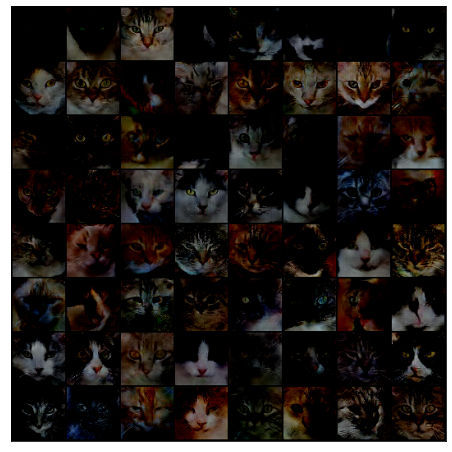

In [ ]:
save_samples(0, fixed_latent)